In [3]:
__author__= 'Emily Ye Hua'
import pandas as pd

/Users/yehua/workspace/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Cross-sectional Analysis on
### PsychSignal sentiment data and AAII Sentiment Survey

### Goal:
Show PsychSignal Data (realeased on daily basis) could be used for nowcasting AAII Sentiment Survey(realeased on weekly basis) through cross-sectional analysis. 

#### This document records detailed steps of pre-processing PsychSignal data and come up with the sectional aggregated sentiment score. 
Using the Financial Sector as an example, I **correlated** aggregated PsychSignal bullish intensity index [Financial Sector] with AAII sentiment bullish score, and the result produced -0.17 correlation coefficient. 

### (1) Understanding Data

##### Psychsignal data contains individual twitte with sentiment score attached to it. 
the sentiment score is on 0-4 scale, with 4 being the most extreme

---

##### There are 457 GICS symbol tickers in PyschSignal data

Also 492 unique symbol in PsychSignal S&P500 dataset

47 Symbols occured in *current S&P500 list* but missing in PsychSignal are:

['AAL', 'AAP', 'ANTM', 'ATVI', 'BF-B', 'BRK-B', 'BXLT', 'CFG', 'CHD', 'CPGX', 'CSRA', 'CXO', 'DISCK', 'ENDP', 'EQIX', 'ES', 'EXR', 'FOX', 'FRT', 'GOOGL', 'HBI', 'HCA', 'HPE', 'HRB', 'HSIC', 'ILMN', 'JBHT', 'KHC', 'LVLT', 'NWS', 'O', 'PYPL', 'QRVO', 'RCL', 'SIG', 'SLG', 'SWKS', 'SYF', 'TGNA', 'TYC', 'UAL', 'VIAB', 'VRSK', 'WBA', 'WLTW', 'WRK', 'ZBH']

35 Symbols occured in *PyschSignal* but missing in current S&P 500 list are:

['ACE', 'ACT', 'ALTR', 'AVP', 'BMS', 'BRCM', 'CFN', 'COV', 'CSC', 'DNR', 'DTV', 'FDO', 'FOSL', 'GCI', 'GNW', 'HCBK', 'HSP', 'JBL', 'KRFT', 'LO', 'MWV', 'NBR', 'NE', 'NU', 'PCL', 'PCP', 'PETM', 'PLL', 'QEP', 'SIAL', 'SWY', 'TEG', 'WIN', 'WLP', 'ZMH']

---

earliest date and latest date within PsychSignal dataset are

{2009-07-10, 2016-01-04}

---

##### There are 10 unique GICS industrial sectors: 

['Health Care', 'Materials', 'Industrials', 'Consumer Discretionary', 'Information Technology', 'Consumer Staples', 'Utilities', 'Financials', 'Energy', 'Telecommunications Services']



In [4]:
#816441 rows × 10 columns
df_psch = pd.read_csv('sp500_pyschsignal.csv')
df_psch.shape
df_psch.columns.values

array(['SOURCE', 'SYMBOL', 'TIMESTAMP_UTC', 'BULLISH_INTENSITY',
       'BEARISH_INTENSITY', 'BULL_MINUS_BEAR', 'BULL_SCORED_MESSAGES',
       'BEAR_SCORED_MESSAGES', 'BULL_BEAR_MSG_RATIO',
       'TOTAL_SCANNED_MESSAGES'], dtype=object)

In [5]:
pd.read_csv('sp500_pyschsignal.csv', nrows = 5)

,SOURCE,SYMBOL,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES
0,stocktwits+twitter_withretweets,A,2009-09-06T04:00:00Z,0.00,0.0,0.00,0,0,0.0,1
1,stocktwits+twitter_withretweets,A,2009-10-11T04:00:00Z,2.44,0.0,2.44,1,0,0.0,1
2,stocktwits+twitter_withretweets,A,2009-10-12T04:00:00Z,2.27,0.0,2.27,3,0,0.0,3
3,stocktwits+twitter_withretweets,A,2009-10-20T04:00:00Z,0.00,2.4,-2.40,0,1,0.0,2
4,stocktwits+twitter_withretweets,A,2009-10-21T04:00:00Z,0.00,0.0,0.00,0,0,0.0,2


In [6]:
print("There are %d unique symbol in PsychSignal dataset"%len(list(pd.unique(df_psch['SYMBOL']))))

There are 492 unique symbol in PsychSignal dataset


#### Process timestamp
transform the TIMESTAMP_UTC column to only *year-month-date* value and drop the UTC time

display the earliest date in the dataset and the latest date in the dataset

In [7]:
from dateutil.parser import parse
stamp = df_psch['TIMESTAMP_UTC'].str.split('T') 
#stamp[0] = ['2009-09-06', '04:00:00Z']
#stamp[0][0] = '2009-09-06'
#let's drop the UTC part
df_psch['TIMESTAMP_UTC'] = stamp.str[0]
df_psch_sorted = df_psch.sort_values(by='TIMESTAMP_UTC')
unique_time_stamps = list(pd.unique(df_psch_sorted['TIMESTAMP_UTC']))
print("earliest date: %s; latest date: %s"%(df_psch['TIMESTAMP_UTC'].min(), df_psch['TIMESTAMP_UTC'].max()))

earliest date: 2009-07-10; latest date: 2016-01-04


#### GICS
Global Industry Classification Standard

In [8]:
#specifies the encode method otherwise it says utf8 can't decode byte at position 4
df_GICS = pd.read_csv('GICS.csv', encoding = "ISO-8859-1")

In [9]:
pd.read_csv('GICS.csv', nrows = 5)

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,A,Agilent Technologies Inc,Health Care,Health Care Equipment & Services,"Santa Clara, California",NaN,1090872
1,AA,Alcoa Inc,Materials,Aluminum,"New York, New York",NaN,4281
2,AAL,American Airlines Group,Industrials,Airlines,"Fort Worth, Texas",3/23/15,6201
3,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/15,1158449
4,AAPL,Apple Inc.,Information Technology,Computer Hardware,"Cupertino, California",11/30/82,320193


In [10]:
print("%d unique GICS industrial sector: "%len(list(pd.unique(df_GICS["GICS Sector"]))))
print(list(pd.unique(df_GICS["GICS Sector"])))

10 unique GICS industrial sector: 
['Health Care', 'Materials', 'Industrials', 'Consumer Discretionary', 'Information Technology', 'Consumer Staples', 'Utilities', 'Financials', 'Energy', 'Telecommunications Services']


#### Find the ticker symbol that is in GICS but not in PsychSignal data; and the otherway around

In [11]:
pysch_symbol = list(pd.unique(df_psch['SYMBOL']))
GICS_symbol = list(pd.unique(df_GICS['Ticker symbol']))
GICS_missing_symbol = []
pysch_adding_symbol = []

for symbol in GICS_symbol:
    if symbol not in pysch_symbol:
        GICS_missing_symbol.append(symbol)
for symbol in pysch_symbol:
    if symbol not in GICS_symbol:
        pysch_adding_symbol.append(symbol)

print("**********GICS_missing_symbol**: %d *******************"%len(GICS_missing_symbol))
print(GICS_missing_symbol)
print("**********pysch_additional_symbol**: %d *******************"%len(pysch_adding_symbol))
print(pysch_adding_symbol)

#filtered = df_psch[(df_psch['SYMBOL'] == 'ACE')]
#print(filtered)


**********GICS_missing_symbol**: 47 *******************
['AAL', 'AAP', 'ANTM', 'ATVI', 'BF-B', 'BRK-B', 'BXLT', 'CFG', 'CHD', 'CPGX', 'CSRA', 'CXO', 'DISCK', 'ENDP', 'EQIX', 'ES', 'EXR', 'FOX', 'FRT', 'GOOGL', 'HBI', 'HCA', 'HPE', 'HRB', 'HSIC', 'ILMN', 'JBHT', 'KHC', 'LVLT', 'NWS', 'O', 'PYPL', 'QRVO', 'RCL', 'SIG', 'SLG', 'SWKS', 'SYF', 'TGNA', 'TYC', 'UAL', 'VIAB', 'VRSK', 'WBA', 'WLTW', 'WRK', 'ZBH']
**********pysch_additional_symbol**: 35 *******************
['ACE', 'ACT', 'ALTR', 'AVP', 'BMS', 'BRCM', 'CFN', 'COV', 'CSC', 'DNR', 'DTV', 'FDO', 'FOSL', 'GCI', 'GNW', 'HCBK', 'HSP', 'JBL', 'KRFT', 'LO', 'MWV', 'NBR', 'NE', 'NU', 'PCL', 'PCP', 'PETM', 'PLL', 'QEP', 'SIAL', 'SWY', 'TEG', 'WIN', 'WLP', 'ZMH']


#### AAII sentiment survey since 1987

In [12]:
#1494 rows × 13 columns
df_AAII = pd.read_csv('AAII.csv')

In [13]:
pd.read_csv('AAII.csv', nrows = 5)

,ReportedDate,Bullish,Neutral,Bearish,Total,Bullish 8-week Mov Avg,Bull-Bear Spread,Bullish Average,"Bullish Average =""+St. Dev.""","Bullish Average=""- St. Dev.""",S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
0,6-26-87,NaN,NaN,NaN,NaN,NaN,NaN,0.0%,0.0%,0.0%,NaN,NaN,NaN
1,7-17-87,NaN,NaN,NaN,NaN,NaN,NaN,0.0%,0.0%,0.0%,314.59,307.63,314.59
2,7-24-87,36.0%,50.0%,14.0%,100%,NaN,22.0%,0.0%,0.0%,0.0%,311.39,307.81,309.27
3,7-31-87,26.0%,48.0%,26.0%,100%,NaN,0.0%,0.0%,0.0%,0.0%,318.66,310.65,318.66
4,8-7-87,56.0%,15.0%,29.0%,100%,NaN,27.0%,0.0%,0.0%,0.0%,323.00,316.23,323.00


#### Convert the percentage from *string* type to *float*

In [14]:
#remember only execute it once!
df_AAII = pd.read_csv('AAII.csv')
"""convert_to_float(df_AAII) # --> df_AAII with "Bullish", "Neutral", "Bearish" set to float 
:param df_AAII: the dataframe to be processed
:type df_AAII: pandas.core.frame.DataFrame
:return: df_AAII DataFrame with float type column for the sentiment type
"""
def convert_to_float(df_AAII):
    sentimentList = ["Bullish", "Neutral", "Bearish"]
    for i in range(len(sentimentList)):
        sentimentType = sentimentList[i]
        df_AAII[sentimentType] = df_AAII[sentimentType].replace('%','',regex=True).astype('float')/100
    return df_AAII
df_AAII_float = convert_to_float(df_AAII)



In [15]:
df_AAII_float.tail()

,ReportedDate,Bullish,Neutral,Bearish,Total,Bullish 8-week Mov Avg,Bull-Bear Spread,Bullish Average,"Bullish Average =""+St. Dev.""","Bullish Average=""- St. Dev.""",S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
1489,1-28-16,0.2975,0.3028,0.3996,100%,24.40%,-10.2%,0.0%,0.0%,0.0%,"1,916.99","1,812.29","1,882.95"
1490,2-4-16,0.2755,0.3774,0.3472,100%,24.28%,-7.2%,0.0%,0.0%,0.0%,"1,947.20","1,872.23","1,912.53"
1491,2-11-16,0.1924,0.3206,0.4870,100%,23.70%,-29.5%,0.0%,0.0%,0.0%,"1,935.26","1,828.46","1,851.86"
1492,2-18-16,0.2756,0.3464,0.3780,100%,23.85%,-10.2%,0.0%,0.0%,0.0%,"1,930.68","1,810.10","1,926.82"
1493,2-25-16,0.3119,0.3739,0.3142,100%,24.61%,-0.2%,0.0%,0.0%,0.0%,"1,946.70","1,871.44","1,929.80"


#### Plot the processed AAII sentiment score 

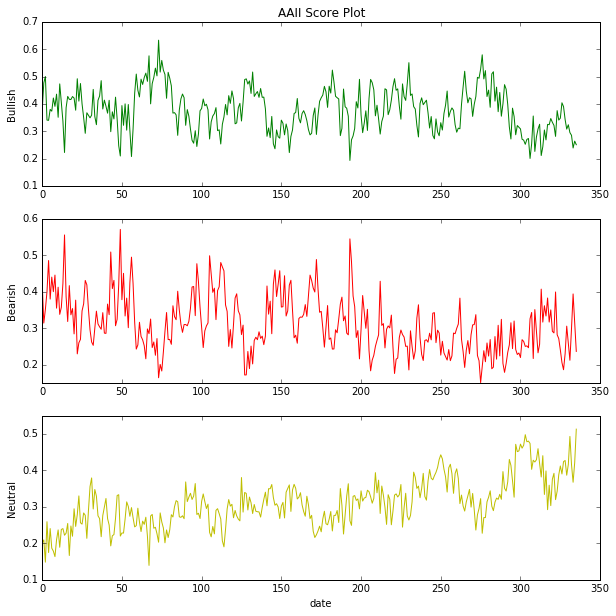

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

#unique_time_stamps == list(pd.unique(df_psch['TIMESTAMP_UTC']))
df_AAII["ReportedDate"] = pd.to_datetime(df_AAII["ReportedDate"])
filtered_df_AAII = df_AAII_float[df_AAII_float['ReportedDate'].isin(unique_time_stamps)].reset_index(drop=True)

# = plot AAII score = #
plt.figure(figsize=[10,10])
plt.subplot(3,1,1)
plt.plot(filtered_df_AAII["Bullish"], 'g-')
plt.title ('AAII Score Plot')
plt.ylabel('Bullish')
plt.subplot(3,1,2)
plt.plot(filtered_df_AAII["Bearish"], 'r-')
plt.ylabel('Bearish')
plt.subplot(3,1,3)
plt.plot(filtered_df_AAII["Neutral"], 'y-')
plt.ylabel('Neutral')
plt.xlabel('date')


### (2) Correlation - first attempt on the Financial Sector

#### Create new Dataframe by filtering current S&P500 against PsychSignal ticker symbol

In [17]:
df_psy_sp500 = df_GICS[df_GICS['Ticker symbol'].isin(df_psch['SYMBOL'])]
print ("there are %d S&P500 ticker in PyschSignal data"%len(df_psy_sp500))
df_psy_sp500[0:1] #preview


there are 457 S&P500 ticker in PyschSignal data


,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,A,Agilent Technologies Inc,Health Care,Health Care Equipment & Services,"Santa Clara, California",NaN,1090872


#### Group tickers by GICS industrial sector

In [22]:
df_psy_sp500.groupby(['GICS Sector']).groups.keys()
sector_name = "Financials"
print("%d symbols are in %s\n"%(len(df_psy_sp500.groupby(['GICS Sector']).groups[sector_name]), sector_name))

#store all symbols that are inside the financial sector
symbol_in_financials = []
index_in_sector_list = df_psy_sp500.groupby(['GICS Sector']).groups[sector_name]
print (index_in_sector_list)

#counter = 0
#print (df_psy_sp500.loc[488])
for index in range(len(index_in_sector_list)):
    #print(index_in_sector_list[index])
    sbl = df_psy_sp500.loc[index_in_sector_list[index]]['Ticker symbol']
    #counter += 1 
    symbol_in_financials.append(df_psy_sp500.loc[index_in_sector_list[index]]['Ticker symbol'])
    #print (counter)
print (symbol_in_financials)    



80 symbols are in Financials

[20, 22, 23, 24, 26, 31, 33, 34, 38, 45, 48, 51, 54, 58, 62, 63, 70, 71, 77, 78, 81, 91, 94, 96, 102, 126, 150, 159, 163, 165, 182, 196, 208, 214, 217, 218, 221, 232, 236, 247, 253, 256, 258, 268, 276, 278, 281, 287, 294, 297, 298, 303, 313, 316, 320, 322, 335, 349, 358, 360, 364, 366, 373, 374, 387, 400, 412, 416, 418, 438, 441, 442, 456, 461, 469, 473, 479, 488, 493, 502]
['AFL', 'AIG', 'AIV', 'AIZ', 'ALL', 'AMG', 'AMP', 'AMT', 'AON', 'AVB', 'AXP', 'BAC', 'BBT', 'BEN', 'BK', 'BLK', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CINF', 'CMA', 'CME', 'COF', 'DFS', 'EFX', 'EQR', 'ESS', 'ETFC', 'FITB', 'GGP', 'GS', 'HBAN', 'HCN', 'HCP', 'HIG', 'HST', 'ICE', 'IVZ', 'JPM', 'KEY', 'KIM', 'L', 'LM', 'LNC', 'LUK', 'MAC', 'MCO', 'MET', 'MHFI', 'MMC', 'MS', 'MTB', 'NAVI', 'NDAQ', 'NTRS', 'PBCT', 'PFG', 'PGR', 'PLD', 'PNC', 'PRU', 'PSA', 'RF', 'SCHW', 'SPG', 'STI', 'STT', 'TMK', 'TROW', 'TRV', 'UNM', 'USB', 'VNO', 'VTR', 'WFC', 'WY', 'XL', 'ZION']


In [23]:
#is there a bug? no~
for index in range(len(index_in_sector_list)):
    if (df_psy_sp500.loc[index_in_sector_list[index]]['GICS Sector']) != 'Financials':
        print ("error: incorrect sector spotted; debug required")
        break;

#### Gen AAII sentiment survey yearly stats
gives you stats includes mean and std

In [129]:
#get series of time stamp from AAII sentiment survey
#store in @unique_AAII_timeStamps where each element is a pandas.tslib.Timestamp
unique_AAII_timeStamps = list(df_AAII_float[df_AAII_float['ReportedDate'].isin(unique_time_stamps)]['ReportedDate'])
print("There are %d unique AAII time stamps in PsychSignal datasets"%len(unique_AAII_timeStamps))
df_psch_sorted["TIMESTAMP_UTC"] = pd.to_datetime(df_psch_sorted["TIMESTAMP_UTC"])
#by far df_psch_sorted["TIMESTAMP_UTC"][0]:= Timestamp('2009-09-06 00:00:00')
df_timeIndex = df_psch_sorted.set_index('TIMESTAMP_UTC')
#now df_timeIndex have TIMESTAMP_UTC as its index
grouped_byYear = df_timeIndex.groupby(lambda x: x.year)
summary = grouped_byYear.describe()


There are 336 unique AAII time stamps in PsychSignal datasets


In [140]:
summary[57:64] #preview year 2016

BULLISH_INTENSITY  BEARISH_INTENSITY  BULL_MINUS_BEAR  \
2016 mean           1.202483           0.770579         0.431904   
     std            0.990018           1.059160         1.280965   
     min            0.000000           0.000000        -3.330000   
     25%            0.000000           0.000000        -0.090000   
     50%            1.590000           0.000000         0.000000   
     75%            2.100000           1.890000         1.690000   
     max            3.100000           4.000000         3.000000   

           BULL_SCORED_MESSAGES  BEAR_SCORED_MESSAGES  BULL_BEAR_MSG_RATIO  \
2016 mean              5.784850              3.296686             0.926002   
     std              32.463915             33.002685             2.342827   
     min               0.000000              0.000000             0.000000   
     25%               0.000000              0.000000             0.000000   
     50%               1.000000              0.000000             0.000000   
     75%               4.000000              2.000000             0.830000   
     max            1139.000000           1200.000000            30.000000   

           TOTAL_SCANNED_MESSAGES  
2016 mean               46.443977  
     std               198.037882  
     min                 1.000000  
     25%                 5.000000  
     50%                12.000000  
     75%                34.000000  
     max              5430.000000

#### [Financial Sector]

In [25]:
#@symbol_in_financials: list of symbols in the financial sector
#filter df_timeIndex by symbols in the financial sector
df_timeIndex_f = df_timeIndex[df_timeIndex['SYMBOL'].isin(symbol_in_financials)]
#now the df_timeIndex_f is PsychSignal dataframe that only contains symbol in the financial sector (sorted by time)
#preview the first 5 entries here
df_timeIndex_f[:5]

,SOURCE,SYMBOL,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES
TIMESTAMP_UTC,,,,,,,,,
2009-07-14,stocktwits+twitter_withretweets,GS,1.52,0.0,1.52,1,0,0.0,1
2009-07-17,stocktwits+twitter_withretweets,GS,0.00,0.0,0.00,0,0,0.0,1
2009-08-06,stocktwits+twitter_withretweets,GS,0.00,0.0,0.00,0,0,0.0,3
2009-08-14,stocktwits+twitter_withretweets,MAC,0.00,0.0,0.00,0,0,0.0,1
2009-08-14,stocktwits+twitter_withretweets,AXP,0.00,0.0,0.00,0,0,0.0,1


In [52]:
df_timeIndex_f['TIMESTAMP'] = df_timeIndex_f.index
timeStampsPSF = list(pd.unique(df_timeIndex_f['TIMESTAMP'])) #type(timeStampsPSF[0]): numpy.datetime64

In [55]:
len(timeStampsPSF)

2316

#### [Financial Sector] Get the list of unique cross matching time stamps
between AAII and PsychSignal and 
stored in *timeStampsF* 

In [89]:
#get the list of time stamps that is the cross-match of AAII[Financial] and PSY[Financial]
timeStampsF = list(df_AAII_float[df_AAII_float['ReportedDate'].isin(timeStampsPSF)]['ReportedDate'])

In [90]:
len(timeStampsF)

334

In [91]:
print ("the last time stamp from the timeStampsF is ", timeStampsF[-1])

the last time stamp from the timeStampsF is  2015-12-31 00:00:00


In [92]:
timeStampsF[-1]

Timestamp('2015-12-31 00:00:00')

In [93]:
len(timeStampsF)

334

In [30]:
filtered_df_AAII.tail()

,ReportedDate,Bullish,Neutral,Bearish,Total,Bullish 8-week Mov Avg,Bull-Bear Spread,Bullish Average,"Bullish Average =""+St. Dev.""","Bullish Average=""- St. Dev.""",S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
331,2015-12-03,0.2949,0.4931,0.2120,100%,34.39%,8.3%,0.0%,0.0%,0.0%,"2,104.27","2,070.29","2,079.51"
332,2015-12-10,0.2851,0.4161,0.2989,100%,33.69%,-1.4%,0.0%,0.0%,0.0%,"2,104.27","2,036.53","2,047.62"
333,2015-12-17,0.2387,0.3675,0.3938,100%,32.33%,-15.5%,0.0%,0.0%,0.0%,"2,080.33","1,993.26","2,073.07"
334,2015-12-24,0.2638,0.4213,0.3149,100%,30.58%,-5.1%,0.0%,0.0%,0.0%,"2,076.72","1,993.26","2,064.29"
335,2015-12-31,0.2507,0.5131,0.2362,100%,28.84%,1.5%,0.0%,0.0%,0.0%,"2,081.56","2,005.93","2,063.36"


#### [Financial Sector] Aggregate PsychSignal Bullish Intensity score
using df[colname].mean()  
df_timeIndex_f: the dataframe we are going to work on (uses timeStamps as index, and sorted by it)

In [94]:
import datetime
#import timestamp
#now let's get the aggregated bullish_intensity by time range coming from AAII sentiment survey
#@unique_AAII_timeStamps: stores the unique time stamp from AAII sentiment survey
#@df_timeIndex_f: the dataframe we are going to work on (uses timeStamps as index, and sorted by it)
#@bullish_aggregatedScore stores the aggregated Bullish score
#@df_sliced contains the PsychSignal data within AAII's time range
#debug print(df.loc['2000-6-1':'2000-6-10'])
bullish_aggregatedScore = []

for t in range(len(timeStampsF)-1):
    start = timeStampsF[t].date()
    end = timeStampsF[t+1].date()
    df_sliced = df_timeIndex_f.loc[start:end]
    # divided by 4 to normalize the data
    bullish_aggregatedScore.append(round(df_sliced['BULLISH_INTENSITY'].mean()/4,3))
    
print (len(bullish_aggregatedScore))

333


In [95]:
#double check the time frame, does they match between AAII and PYS? Yes
a = unique_AAII_timeStamps[2].date()
b = unique_AAII_timeStamps[3].date()
print (a)
print (b)
df_timeIndex_f.loc[a:b]

2009-08-06
2009-08-20


,SOURCE,SYMBOL,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,TIMESTAMP
TIMESTAMP_UTC,,,,,,,,,,
2009-08-06,stocktwits+twitter_withretweets,GS,0.00,0.00,0.00,0,0,0.0,3,2009-08-06
2009-08-14,stocktwits+twitter_withretweets,MAC,0.00,0.00,0.00,0,0,0.0,1,2009-08-14
2009-08-14,stocktwits+twitter_withretweets,AXP,0.00,0.00,0.00,0,0,0.0,1,2009-08-14
2009-08-14,stocktwits+twitter_withretweets,BBT,1.63,0.00,1.63,3,0,0.0,3,2009-08-14
2009-08-14,stocktwits+twitter_withretweets,NDAQ,0.00,0.00,0.00,0,0,0.0,1,2009-08-14
2009-08-18,stocktwits+twitter_withretweets,CCI,0.00,0.00,0.00,0,0,0.0,1,2009-08-18
2009-08-18,stocktwits+twitter_withretweets,BK,2.25,0.00,2.25,2,0,0.0,2,2009-08-18
2009-08-20,stocktwits+twitter_withretweets,C,1.61,0.00,1.61,1,0,0.0,1,2009-08-20
2009-08-20,stocktwits+twitter_withretweets,AIG,1.56,2.07,-0.51,2,1,2.0,8,2009-08-20


#### Get the AAII bullish score

make sure the time stamp matches

In [153]:
#unique_time_stamps = list(pd.unique(df_psch['TIMESTAMP_UTC']))
#@filtered_df_AAII stores AAII sentiment data which has overlapping time frame as PsychSignal's
df_AAII["ReportedDate"] = pd.to_datetime(df_AAII["ReportedDate"])
filtered_df_AAII = df_AAII_float[df_AAII_float['ReportedDate'].isin(timeStampsF)].reset_index(drop=True)

In [154]:
len(timeStampsF) #should have 1 more time stamp than AAII's

334

In [155]:
#get rid of the above 2009-08-06 time stamps, as the first aggregated PsychSignal sentiment score starts from 2009-08-20
filtered_df_AAII = filtered_df_AAII[1:]

In [156]:
filtered_df_AAII['ReportedDate'].iloc[0]

Timestamp('2009-08-20 00:00:00')

In [158]:
len(filtered_df_AAII) 
#now, the original first time stamp 2009-08-06 is removed, as the Psy aggregated score starts from 2016-08-20

333

#### [Financial Sector] Plot AAII Sentiment Score against aggregated PsychSignal Sentiment Score

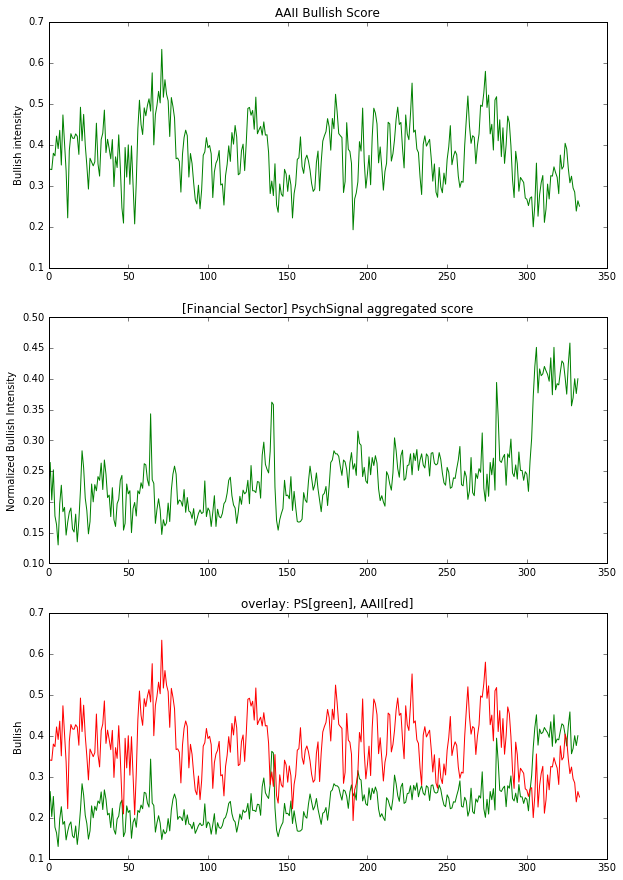

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt

# = plot = #
plt.figure(figsize=[10,15])
plt.subplot(3,1,1)
plt.plot(filtered_df_AAII['Bullish'], 'g-')
plt.title('AAII Bullish Score')
plt.ylabel('Bullish intensity')
plt.subplot(3,1,2)
plt.plot(bullish_aggregatedScore, 'g-')
plt.title('[Financial Sector] PsychSignal aggregated score')
plt.ylabel('Normalized Bullish Intensity')
plt.subplot(3,1,3)
plt.plot(bullish_aggregatedScore, 'g-',filtered_df_AAII['Bullish'], 'r-')
plt.title('overlay: PS[green], AAII[red]')
plt.ylabel('Bullish ')

#### [Financial Sector] Correlate PsychSignal aggregated score and AAII score
using Pearson correlation:
$\rho = \frac{cov(X,Y)}{\sigma_x \sigma_y} $

only a very weak negative correlation exhibited between AAII and PsychSignal Financial Sector's aggregated score; could indicate that the financial sector is too volatile and [Financial Sector's] twitter sentiment and AAII survey sentiment do not vibrate together very well. (Will be interesting to look at other industrial sectors using the same approach; though need to bear in mind that AAII and PsychSignal use different approaches of coming up with their sentiment scores)

In [151]:
import numpy
AAIIBullish = filtered_df_AAII['Bullish'].tolist()
print (len(AAIIBullish))
print (len(bullish_aggregatedScore))

333
333


In [152]:
numpy.corrcoef(AAIIBullish, bullish_aggregatedScore)

array([[ 1.        , -0.16969656],
       [-0.16969656,  1.        ]])